# Cheat sheet - Option Pricing with Black-Scholes

### by François Goujon

Black-Scholes : 

$Call = S \mathcal{N}(d_1) - e^{-rT}K \mathcal{N}(d_2)$ <br>
$Put = - S \mathcal{N}(-d_1) + e^{-rT}K \mathcal{N}(-d_2)$

Where : $d_1 = \frac{1}{\sigma\sqrt{T}} (\log(\frac{S}{K}) + (r + \frac{\sigma^2}{2})t) \ $ and $ \ d_2 = d_1 - \sigma\sqrt{T}$

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### Functions

In [65]:
def d1(s, k, sigma, t, r):
    """
    Computes d1 in BS model
    
    Inputs:
    - s0: spot (initial underlying asset price)
    - k: strike
    - sigma: volatility of underlying
    - t: time to maturity
    - r: risk free rate

    Output:
    - d1
    """
    return (np.log(s/k) + (r + (sigma**2)/2)*t)/(sigma*np.sqrt(t))

def d2(s, k, sigma, t, r):
    """
    Computes d2 in BS model
    """
    return d1(s, k, sigma, t, r) - sigma*np.sqrt(t)

def call(s, k, sigma, t, r):
    """
    Computes call premium with BS model
    """
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    return s*norm.cdf(d1_) - k*np.exp(-r*t)*norm.cdf(d2_)

def put(s, k, sigma, t, r):
    """
    Computes put premium with BS model
    """
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    return - s*norm.cdf(-d1_) + k*np.exp(-r*t)*norm.cdf(-d2_)

def proba_ITM(s, k, sigma, t, r, option="call"):
    """
    Computes probability of option ITM : 
    Call : S_T > K ; Put : S_T < K
    """
    d2_ = d2(s, k, sigma, t, r)
    if option == "call":
        return norm.cdf(d2_)
    elif option == "put":
        return norm.cdf(-d2_)
    else:
        print("Option not supported")

def compute_delta(s, k, sigma, t, r, option="call"):
    d1_ = d1(s, k, sigma, t, r)
    if option == "call":
        return norm.cdf(d1_)
    elif option == "put":
        return norm.cdf(-d1_)
    else:
        print("Option not supported")
        
def compute_vega(s, k, sigma, t, r):
    d1_ = d1(s, k, sigma, t, r)
    vega = s*norm.pdf(d1_)*np.sqrt(t)*0.01
    return vega

def compute_gamma(s, k, sigma, t, r):
    d1_ = d1(s, k, sigma, t, r)
    gamma = norm.pdf(d1_)/(s*sigma*np.sqrt(t))
    return gamma

def compute_rho(s, k, sigma, t, r, option="call"):
    d2_ = d2(s, k, sigma, t, r)
    if option == "call":
        rho = k*t*np.exp(-r*t)*norm.cdf(d2_)*0.01
        return rho
    elif option == "put":
        rho = -k*t*np.exp(-r*t)*norm.cdf(-d2_)*0.01
        return rho
    else:
        print("Option not supported")
        
def compute_theta(s, k, sigma, t, r, option="call"):
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    if option == "call":
        theta = -s*norm.pdf(d1_)*0.5*sigma/np.sqrt(t) - r*k*np.exp(-r*t)*norm.cdf(d2_)
        return theta
    elif option == "put":
        theta = -s*norm.pdf(d1_)*0.5*sigma/np.sqrt(t) + r*k*np.exp(-r*t)*norm.cdf(-d2_)
        return rho
    else:
        print("Option not supported")
        
def print_greeks(s, k, sigma, t, r, option="call"):
    params = [s, k, sigma, t, r]
    print(f"For the following parameters : S = {s}, K = {k}, Sigma = {sigma}, T = {t}, r = {r}")
    print(f"Delta = {compute_delta(*params, option=option)}")
    print(f"Vega = {compute_vega(*params)}")
    print(f"Gamma = {compute_gamma(*params)}")
    print(f"Rho = {compute_rho(*params, option=option)}")
    print(f"theta = {compute_theta(*params, option=option)}")


def plot_premium_strike(s, sigma, t, r):
    """
    Plot option premiums depending on strike
    """
    ks = np.arange(0.005*s, 2*s, 0.005*s)
    call_prms = list(map(lambda x : call(s, x, sigma, t, r), ks))
    put_prms = list(map(lambda x : put(s, x, sigma, t, r), ks))
    plt.figure(figsize=(12,6))
    plt.plot(ks, call_prms, label='Call premium', c = "g")
    plt.plot(ks, put_prms, label='Put premium', c = "r")
    plt.axvline(x=s, c="b", label = "S0")
    plt.xlabel("Strike")
    plt.ylabel("Premium")
    plt.legend()
    plt.grid()
    plt.show()
    return ks, call_prms, put_prms

def vol_bs(s0, r, k, t):
    """
    Plot the option premium depending on volatility for the chosen parameters

    Inputs:
    - s0: initial asset price
    - r: risk free rate
    - k: strike price
    - t: time of simulation in years
    - m: number of simulations in MC
    
    Outputs:
    - sigmas: volatilities
    - calls, puts: option premium for the different theta values
    """
    sigmas = np.arange(0.001, 0.7, 0.001)
    calls = call(s0, k, sigmas, t, r)
    puts = put(s0, k, sigmas, t, r)

    fig, axs = plt.subplots(2, 2, figsize=(24,10))
    axs[0,0].plot(sigmas, calls, label="Calls")
    axs[0,0].set_title("Implied volatility (std) Calls")
    axs[1,0].plot(sigmas[:350], calls[:350], label="Calls")
    axs[0,1].plot(sigmas, puts, label="Puts")
    axs[0,1].set_title("Implied volatility (std) Puts")
    axs[1,1].plot(sigmas[:350], puts[:350], label="Puts")
    for ax in axs.flatten():
        ax.set_xlabel("Volatility (std)")
        ax.set_ylabel("Option premium")
        ax.legend()
    plt.show()
    
    return sigmas, calls, puts

def plot_bs(s0, s, sigma, t, r):
    """
    Plot volatility depending on strike
    
    Inputs:
    - s0: initial asset price
    - s: asset price evolution
    - r: risk free rate
    - T: time to maturity
    """
    # Set strikes 
    ks = np.arange(0.2*s0, 2*s0, 0.01*s0)
    
    calls = call(s0, ks, sigma, t, r)
    puts = put(s0, ks, sigma, t, r)
    
    put_impvol = implied_vol_put(puts, s0, ks, t, r) # TODO
    call_impvol = implied_vol_call(calls, s0, ks, t, r) # TODO
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(26, 6))
    ax1.plot(ks, calls, label="Call premiums")
    ax1.plot(ks, puts, label="Put premiums")
    ax1.set_ylabel("Premium")
    ax1.set_xlabel("Strike")
    ax1.set_title("Option premium under BS Model")
    ax1.legend()
    ax2.plot(ks, call_impvol, label="Implied Vol Calls")
    ax2.plot(ks, put_impvol, label="Implied Vol Puts")
    ax2.set_ylabel("Implied vol")
    ax2.set_xlabel("Strike")
    ax2.set_title("Implied vol under Heston Model")
    ax2.legend()
    plt.show()

def plot_payoff(s, k, sigma, t, r, ret = False):
    """
    Plot payoff of options
    """
    pc = call(s, k, sigma, t, r)
    pp = put(s, k, sigma, t, r)
    pc_T = pc*np.exp(r*t)
    pp_T = pp*np.exp(r*t)
    
    sts = np.arange(0, 2*s, 0.005*s)
    call_po = np.array(list(map(lambda x : max(x-k,0) - pc_T, sts)))
    put_po = np.array(list(map(lambda x : max(k-x,0) - pp_T, sts)))
    call_put = call_po - put_po
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 15))
    ax1.plot(sts, call_po, label = "Payoff call", c = "g")
    ax1.plot(sts, put_po, label = "Payoff put", c = "r")
    ax2.plot(sts, call_put, label = "Call - Put payoff", c = "black")
    ax2.plot(sts, call_po, label = "Call payoff", c = "g")
    ax2.plot(sts, -put_po, label = "Put sell payoff", c = "r")
    for ax in [ax1, ax2]:
        ax.axvline(x=s, c="b", label = "S0")
        ax.axvline(x=k, c="deeppink", label = "K")
        ax.set_xlabel(r"$S_T$")
        ax.set_ylabel("PF Value at t = T")
        ax.legend()
        ax.grid()
    plt.show()
    if ret:
        return sts, call_po, put_po, call_put
    
def plot_structured_payoff(s, products, r, t, with_cost=False, plot_all=False):
    """
    Plot payoff of a structured product composed of options, bonds, asset
    
    Inputs:
    products = [{"name": "bond", "params" : [number]},
                {"name" : "option", "params" : ["call/put", "buy/sell", "strike", "vol"]},
                {"name" : "spot", "params" : [nb]}]
    """
    
    sts = np.arange(0, 2*s, 0.005*s)
    n = len(sts)
    payoffs = []
    premiums = [0]
    costs_bonds = [0]
    costs_spot = [0]
    for prod in products:
        # BOND
        if prod["name"] == "bond":
            nb = prod["params"][0]
            bond_po = np.exp(-r*t)*nb*np.ones(n)
            payoffs.append(bond_po)
            costs_bonds.append(nb*np.exp(-r*t))
        
        # OPTION
        elif prod["name"] == "option":
            k = prod["params"][2]
            sigma = prod["params"][3]
            way = 1 if prod["params"][1] == "buy" else -1
            if prod["params"][0] == "call": 
                pc = call(s, k, sigma, t, r)
                #pc_T = pc*np.exp(r*t)
                #call_po = way*np.array(list(map(lambda x : max(x-k,0), sts)))
                call_po = way*np.array(list(map(lambda x : max(np.exp(-r*t)*(x-k),0), sts)))
                payoffs.append(call_po)
                premiums.append(way*pc)
            elif prod["params"][0] == "put": 
                pp = put(s, k, sigma, t, r)
                pp_T = pp*np.exp(r*t)
                #put_po = way*np.array(list(map(lambda x : max(k-x,0), sts)))
                put_po = way*np.array(list(map(lambda x : max(np.exp(-r*t)*(k-x),0), sts)))
                payoffs.append(put_po)
                premiums.append(way*pp)
            else:
                print("Option type not supported")
        
        # Spot
        elif prod["name"] == "spot":
            nb = prod["params"][0]
            spot_po = np.exp(-r*t)*nb*sts
            payoffs.append(spot_po)
            costs_spot.append(s)
            
        else:
            print("Product type not supported")
            
    sum_po = np.array(payoffs).sum(axis=0)
    ct_pr = sum(premiums)
    ct_bd = sum(costs_bonds)
    ct_sp = sum(costs_spot)
    total_cost = ct_pr + ct_bd + ct_sp
    if with_cost:
        sum_po -= total_cost
    plt.figure(figsize=(12,6))
    plt.plot(sts, sum_po, label='PF Value', c = "black")
    if plot_all:
        for po in payoffs:
            plt.plot(sts, po)
    plt.xlabel(r"$S_T$ at t = T")
    plt.ylabel("PF Value at t = 0")
    plt.title("Structured Payoff")
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f"Total premium paid : {ct_pr}")
    print(f"Total bond cost : {ct_bd}")
    print(f"Total spot cost : {ct_sp}")
    print(f"Total initial cost : {total_cost}")
            
    return sts, payoffs, sum_po

In [60]:
S0 = 100 # Spot price
K = 105  # Strike price
T = 1     # Time to maturity in years
r = 0.01  # Risk-free rate
sigma = 0.15 # Volatility 
params = [S0, K, sigma, T, r]

In [61]:
put(*params)

8.276696394464679

In [62]:
call(*params)

4.321463850802019

In [66]:
print_greeks(*params, "call")

For the following parameters : S = 100, K = 105, Sigma = 0.15, T = 1, r = 0.01
Delta = 0.42716320223052956
Vega = 0.3922745843410597
Gamma = 0.026151638956070648
Rho = 0.38394856372250935
theta = -3.326007946280457


In [14]:
# Also work with numpy arrays
call(5000, 5250, np.array([0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]), 1, -0.003)

array([135.18258778, 153.93016077, 172.90317497, 192.05678012,
       211.35663782, 230.7760102 , 250.29375647, 269.89292657,
       289.55975566])

Call-put parity  : $C - P = S - Ke^{-rT}$

In [182]:
print(call(*params) - put(*params))
print(S0 - K*np.exp(-r*T))

-3.9552325436626603
-3.955232543662646


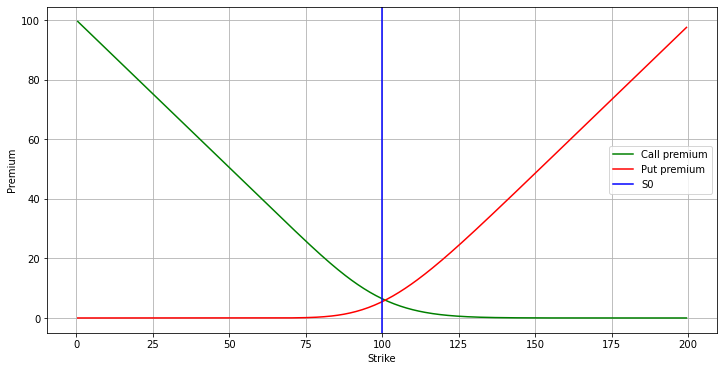

In [183]:
a, b, c = plot_premium_strike(S0, sigma, T, r)

$C = P \Rightarrow K = Se^{rT} = F > S$ : for the same price you have an ITM put and an OTM call

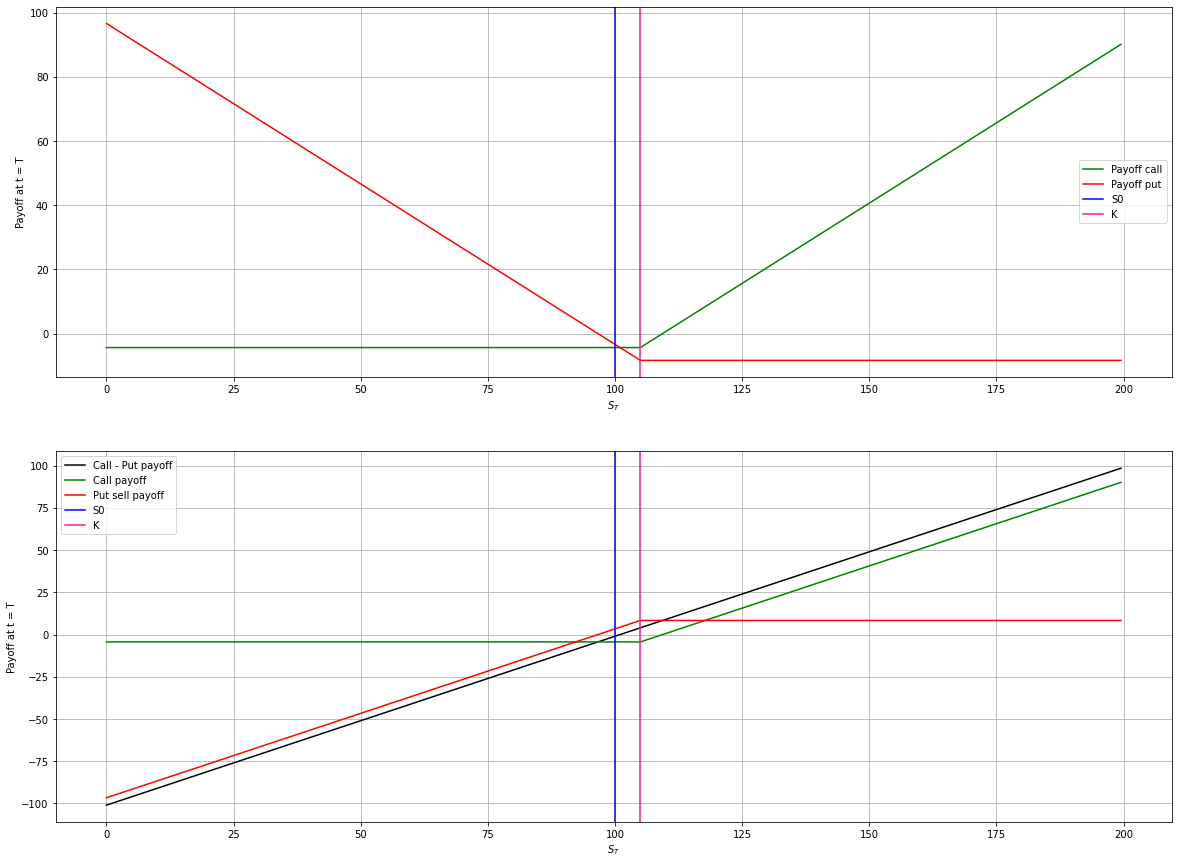

In [189]:
a,b,c,d = plot_payoff(S0, K, sigma, T, r, True)

At $t = 0$ : $V_{t=0} = P - C = e^{-rT}K - S_0 \ (= e^{rT}(P - C) = K - e^{rT}S_0)_{t=T}$ (Sell a put, buy a call) <br>
At $t = T$ : $V_{t=T} = S_T - K$ <br>
So all in all : $V_{t=T} = S_T - K + e^{rT}(P - C) = S_T - e^{rT}S_0 = S_T - F_T$ with $F_T$ the futures value of S at maturity T <br>
Selling a put and buying a call is the same as buying a future

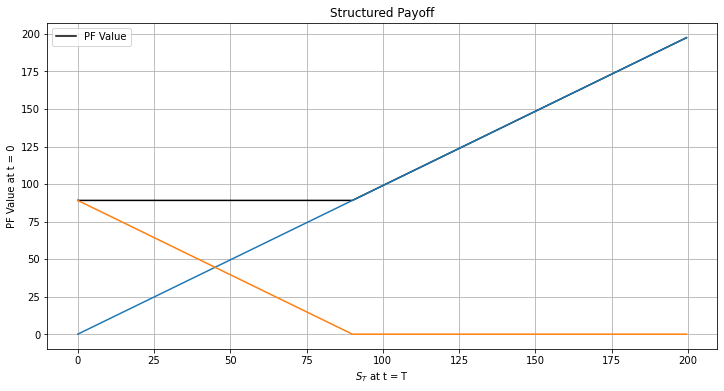

Total premium paid : 1.793865773975078
Total bond cost : 0
Total spot cost : 100
Total initial cost : 101.79386577397509


In [318]:
products = [{"name" : "spot", "params" : [1]},
           {"name" : "option", "params" : ["put", "buy", 90, sigma]}]
a, b, c = plot_structured_payoff(S0, products, r, T, False, True)

Call - Put parity visualized

In [ ]:
products = [{"name" : "bond", "params" : [90]},
           {"name" : "option", "params" : ["call", "buy", 90, sigma]}]
a,b,c = plot_structured_payoff(S0, products, r, T, False, True)

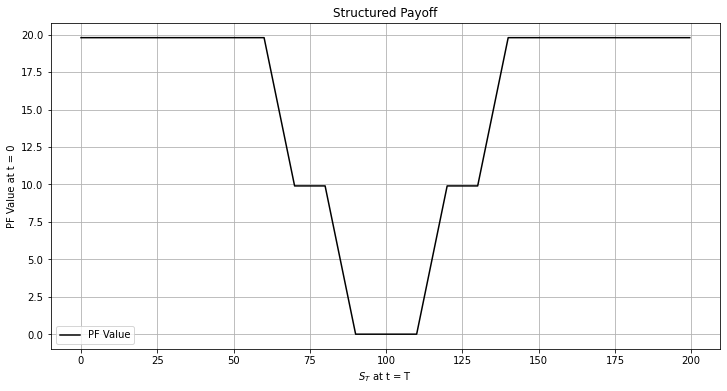

Total premium paid : 3.4672916298407928
Total bond cost : 0
Total spot cost : 0
Total initial cost : 3.4672916298407928


In [323]:
products = [{"name" : "option", "params" : ["put", "buy", 90, sigma]}, 
            {"name" : "option", "params" : ["put", "sell", 80, sigma]},
            {"name" : "option", "params" : ["put", "buy", 70, sigma]}, 
            {"name" : "option", "params" : ["put", "sell", 60, sigma]},
            {"name" : "option", "params" : ["call", "buy", 110, sigma]},
            {"name" : "option", "params" : ["call", "sell", 120, sigma]},
            {"name" : "option", "params" : ["call", "buy", 130, sigma]},
            {"name" : "option", "params" : ["call", "sell", 140, sigma]}]
a,b,c = plot_structured_payoff(100, products, r, T, False, False)

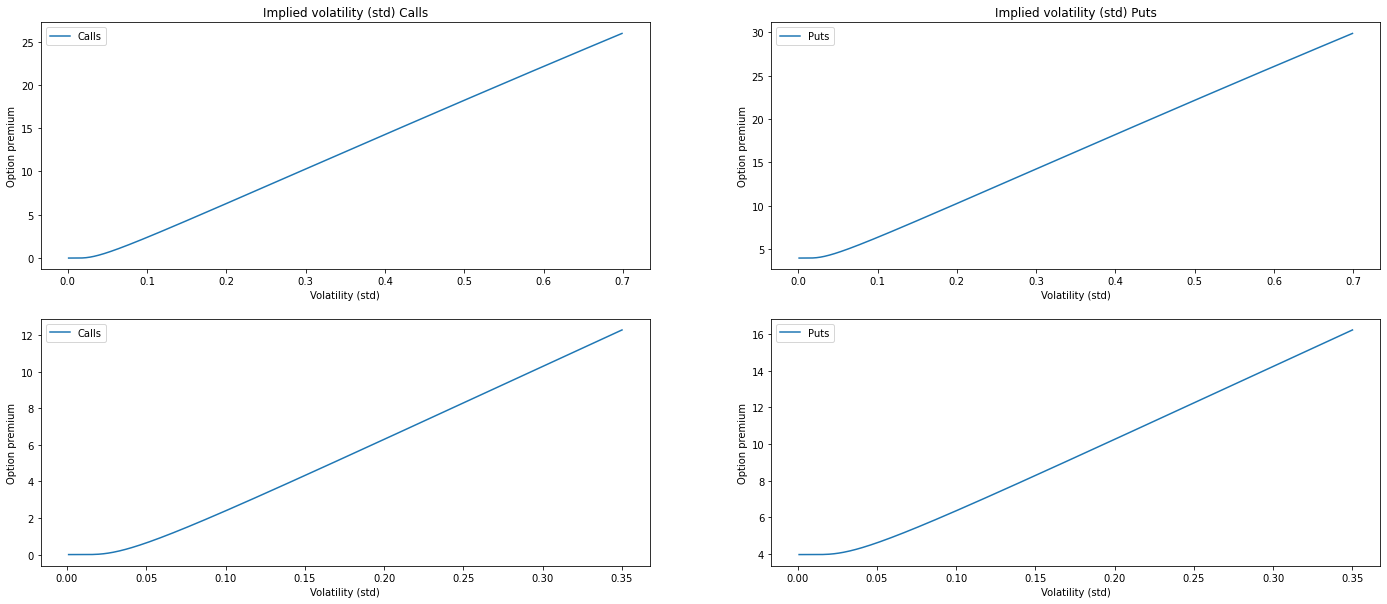

In [52]:
a,b,c = vol_bs(S0, r, K, T)

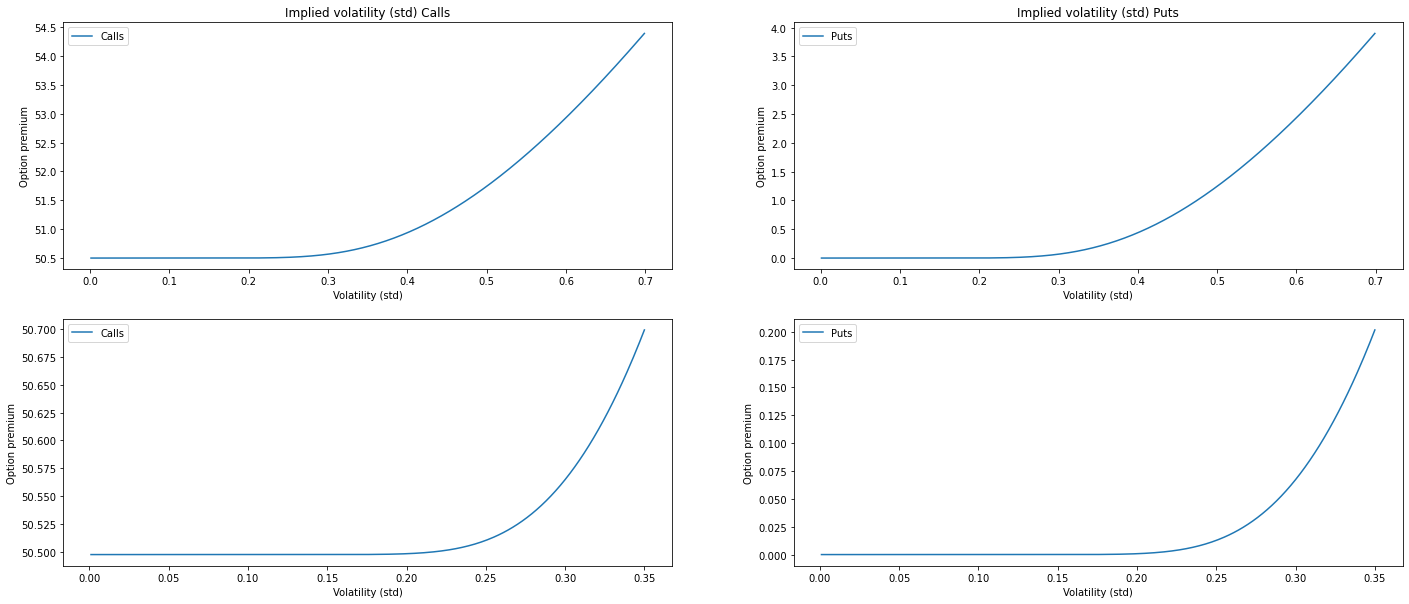

In [53]:
a,b,c = vol_bs(S0, 0.01, 50, T)

## Monte Carlo Simulation

### Price evolution under risk-neutral measure (black-scholes):
$$
\frac{dS_t}{S_t} = rdt + \sigma dW_t = rdt + \sqrt{v} dW_t \\
With \ Y_t = \ln(S_t) \ and \ Ito \rightarrow dY_t = \frac{\partial ln}{\partial x}(S_t)dS_t + \frac{1}{2}\frac{\partial^{2} ln}{\partial x^2}(S_t)d \langle S, S \rangle_t = \frac{dS_t}{S_t} - \frac{1}{2S_t^2}d \langle S, S \rangle_t = \frac{dS_t}{S_t} - \frac{v}{2}dt\\
\quad \\
dY_t = (r - \frac{v}{2})dt + \sqrt{v}dW_t \Rightarrow Y_t = Y_0 + (r - \frac{v}{2})t + \sqrt{v}W_t \\
S_t = e^{Y_t} \Rightarrow S_t = S_{0}e^{(r - \frac{\sigma^2}{2})t + \sigma W_t} = S_{0}e^{(r - \frac{v}{2})t + \sqrt{v}W_t} \quad and \ W_t \sim N(0,t)
$$

### Functions

In [44]:
def bs_model_mc(s0, r, theta, t, m):
    """
    Computes Black-Scholes model simulations for the chosen parameters
    
    Inputs:
    - s0: initial underlying asset price (spot)
    - r: risk free rate
    - theta: variance 
    - t: time to maturity in years
    - m: number of simulations
    
    Outputs:
    - Asset price over time (numpy array)
    """
    s = s0*np.exp((r - 0.5*theta)*t + np.sqrt(theta)*np.random.normal(0,t,m))
    return s

def implied_vol_mc(s0, r, k, t, m):
    """
    Plot the option premium depending on volatility for the chosen parameters

    Inputs:
    - s0: initial asset price
    - r: risk free rate
    - k: strike price
    - t: time of simulation in years
    - m: number of simulations in MC
    
    Outputs:
    - thetas: volatilities
    - calls, puts: option premium for the different theta values
    """
    stds = np.arange(0, 0.7, 0.001)
    thetas = stds**2
    ss = []
    for theta in thetas:
        s = s0*np.exp((r - 0.5*theta)*t + np.sqrt(theta)*np.random.normal(0,t,m))
        ss.append(s)

    puts = []
    calls = []
    for s in ss:
        put = np.exp(-r*t)*np.mean(np.maximum(k-s, 0))
        call = np.exp(-r*t)*np.mean(np.maximum(s-k, 0))
        puts.append(put)
        calls.append(call)

    fig, axs = plt.subplots(2, 2, figsize=(24,10))
    axs[0,0].plot(stds, calls, label="Calls")
    axs[0,0].set_title("Implied volatility (std) Calls")
    axs[1,0].plot(stds[:350], calls[:350], label="Calls")
    axs[0,1].plot(stds, puts, label="Puts")
    axs[0,1].set_title("Implied volatility (std) Puts")
    axs[1,1].plot(stds[:350], puts[:350], label="Puts")
    for ax in axs.flatten():
        ax.set_xlabel("Volatility (std)")
        ax.set_ylabel("Option premium")
        ax.legend()
    plt.show()
    
    return thetas, calls, puts

def plot_bs_mc(s0, s, r, t):
    """
    Plot premium depending on strike
    
    Inputs:
    - s0: initial asset price
    - s: asset price evolution
    - r: risk free rate
    - T: time to maturity
    """
    # Set strikes and complete MC option price for different strikes
    ks = np.arange(0.005*s0, 2*s0, 0.005*s0)

    puts = np.array([np.exp(-r*t)*np.mean(np.maximum(k-s, 0)) for k in ks]) # Mean of difference only at maturity
    calls = np.array([np.exp(-r*t)*np.mean(np.maximum(s-k, 0)) for k in ks])
    
    #put_impvol = implied_vol_call(puts, s0, ks, t, r)
    #call_impvol = implied_vol_put(calls, s0, ks, t, r)
    
    fig, ax1 = plt.subplots(1, figsize=(12, 6))
    ax1.plot(ks, calls, label="Call premiums", c = "g")
    ax1.plot(ks, puts, label="Put premiums", c = "r")
    plt.axvline(x=s0, c="b", label = "S0")
    ax1.set_ylabel("Premium")
    ax1.set_xlabel("Strike")
    ax1.set_title("Option premium under BS Model")
    ax1.legend()
    ax1.grid()
    #ax2.plot(ks, call_impvol, label="Implied Vol Calls")
    #ax2.plot(ks, put_impvol, label="Implied Vol Puts")
    #ax2.set_ylabel("Implied vol")
    #ax2.set_xlabel("Strike")
    #ax2.set_title("Implied vol under Heston Model")
    #ax2.legend()
    plt.show()

In [45]:
s = bs_model_mc(S0, r, sigma**2, T, 10000)

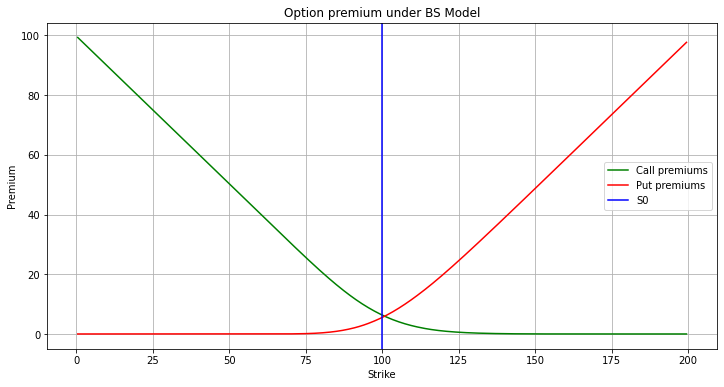

In [46]:
# Monte Carlo
plot_bs_mc(S0, s, r, T)

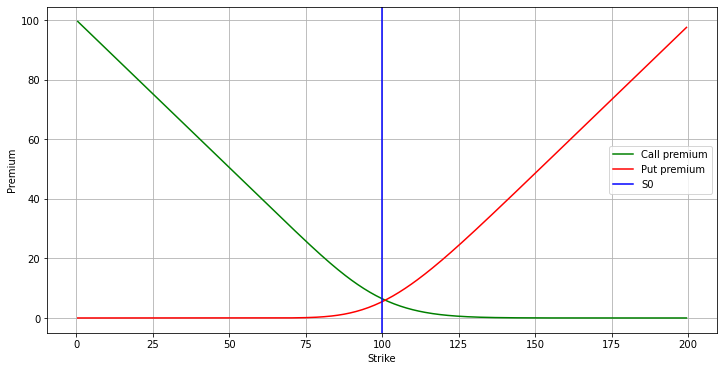

In [48]:
# Analytical 
_ = plot_premium_strike(S0, sigma, T, r)

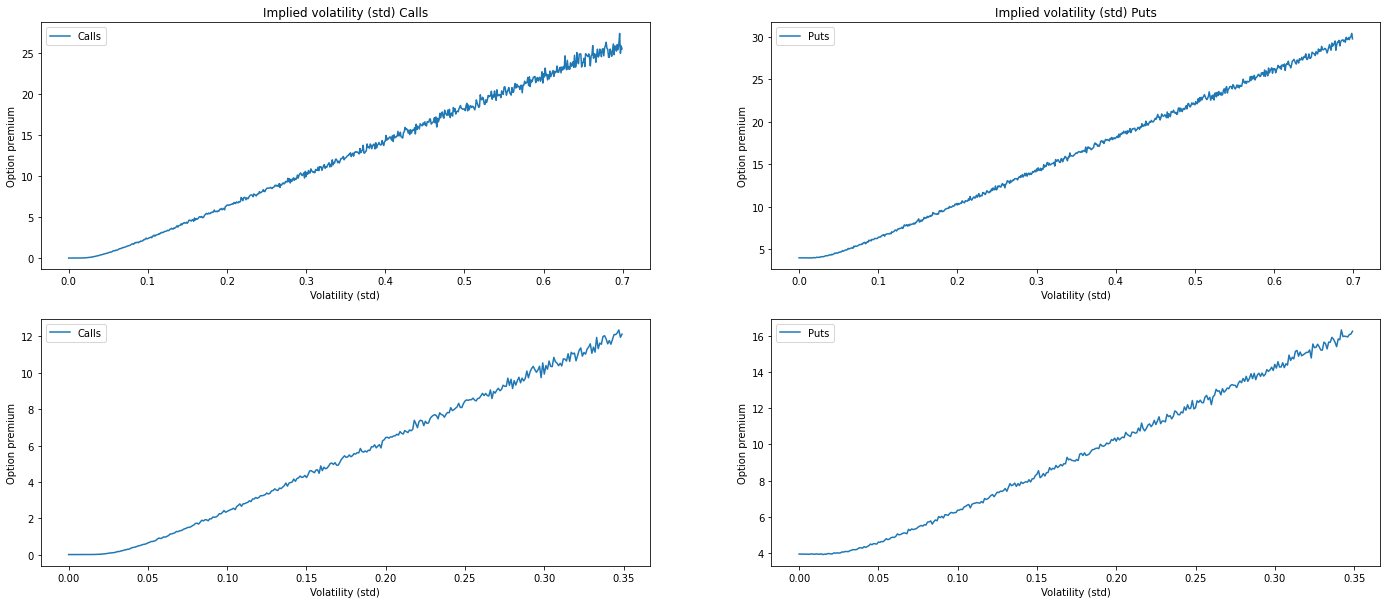

In [54]:
_ = implied_vol_mc(S0, r, K, T, 10000)

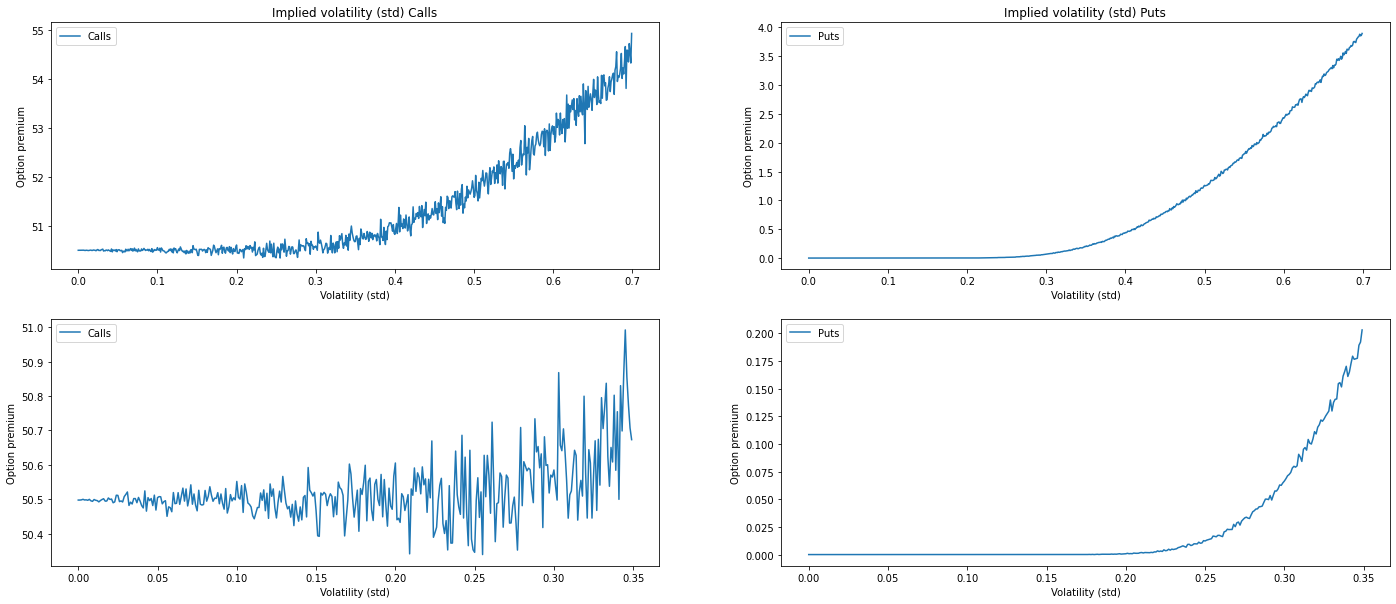

In [57]:
_ = implied_vol_mc(S0, 0.01, 50, T, 100000)

## Use with real data

In [70]:
import yfinance as yf
import pandas as pd
import datetime

In [133]:
def get_data(ticker):
    """
    Retrieve data from yfinance
    Input: ticker (String)
    Output: price dataframe (pd.DataFrame)
    """
    end = datetime.datetime.now()
    start = end - datetime.timedelta(days=365)
    df = yf.Ticker(ticker).history(start=start, end=end, period="1d")
    df.index = df.index.to_series().dt.date
    return df

def plot_daily_returns(data, log=False, squared=False):
    """Plot daily returns and returns them
    Input: data (DataFrame) -> price dataframe
    log (boolean) -> daily log returns ;
    squared (boolean) -> daily squared (normal/log) returns """
    if log:
        d_returns = np.log(data["Close"].pct_change(1).dropna() + 1)
    else:
        d_returns = data["Close"].pct_change(1).dropna()
        
    if squared:
        d_returns = np.square(d_returns)
    d_returns.plot(figsize=(12,6))
    plt.show()
    return d_returns 

def plot_volatility_window(d_returns, window_days=40):
    """Plot volatility overtime by calculating it over a window_days window"""
    vol = d_returns.rolling(window=window_days).std()*np.sqrt(252)
    vol = vol.dropna()
    vol.plot(figsize=(12,6))
    plt.title("Volatility")
    plt.ylabel("Vol")
    plt.show()
    return vol

def plot_US_TBonds(period):
    """
    period = "3M", "5Y", "10Y", "30Y"
    US T-Bonds ^IRX: 3months ; ^FVX: 5years
    ^TNX: 10years ; ^TYX: 30years
    """
    duration = {"3M": "^IRX", "5Y": "^FVX", "10Y": "^TNX", "30Y": "^TYX"}
    ustb = get_data(duration[period])["Close"]
    ustb.plot(figsize=(12,6))
    plt.title(f"US T-Bonds {period}")
    plt.ylabel("Rate in %")
    plt.show()
    return ustb/100

def get_option_data(ticker, t, strike=None, opt_type=None):
    """
    Input: ticker (String) ; t (int) : time to maturity in years
    """
    opt_exp_date = yf.Ticker(ticker).options
    td = datetime.datetime.now()
    days = t*365
    best_expi = ""
    min_diff = np.inf
    for d in opt_exp_date:
        diff = abs((datetime.datetime.strptime(d, '%Y-%m-%d') - td).days - days)
        if diff < min_diff:
            min_diff = diff
            best_expi = d
    print(f"Nearest Expiration date : {best_expi}")
    option = yf.Ticker(ticker).option_chain(date=best_expi)
    if opt_type == "call":
        res = option.calls
        res["type"] = "call"
    elif opt_type == "put":
        res = option.puts
        res["type"] = "put"
    else:
        c = option.calls
        c["type"] = "call"
        p = option.puts
        p["type"] = "put"
        res = pd.concat([c, p], ignore_index=True)
        
    if strike != None:
        res = res[res["strike"] == strike]
    
    res.reset_index(inplace=True)
        
    return res
    

In [152]:
d = get_data("AAPL")

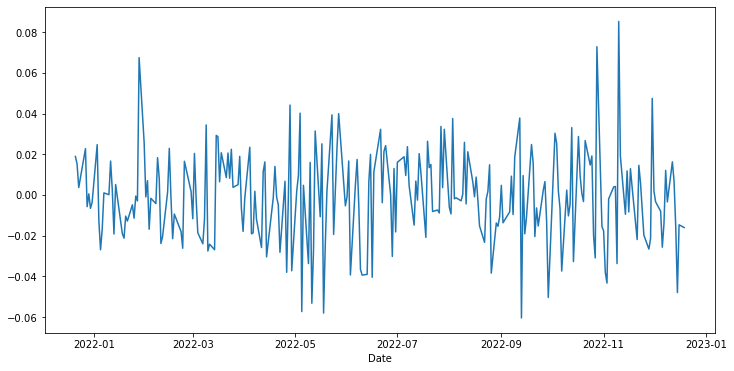

In [153]:
d_returns = plot_daily_returns(d, log=True)

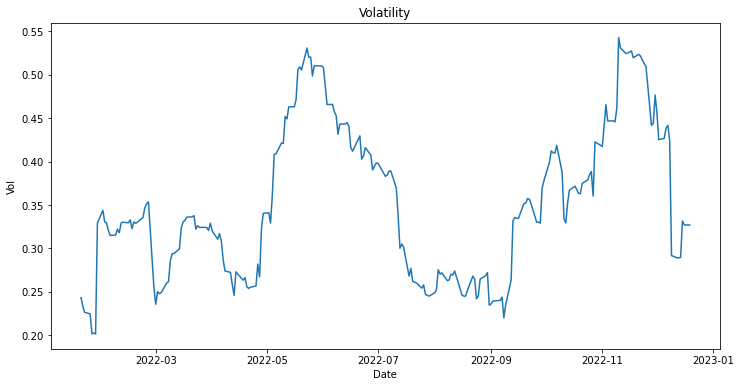

In [164]:
vol = plot_volatility_window(d_returns, 20)

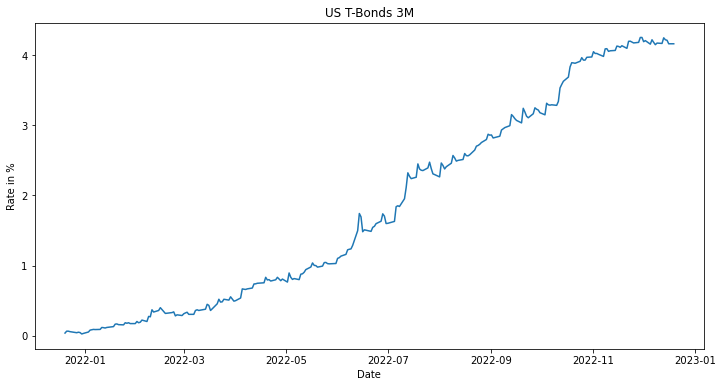

In [165]:
ustb = plot_US_TBonds("3M")

In [166]:
s0 = d["Close"][-1]
K = 140
sigma = vol[-1]
T = 0.25
r = ustb[-1]
params = [s0, K, sigma, T, r]
print(params)

[132.3699951171875, 140, 0.3270279337491689, 0.25, 0.041630001068115235]


In [167]:
call(*params)

6.077030833144683

In [168]:
get_option_data("AAPL", T, K)

Nearest Expiration date : 2023-03-17


,index,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type
0,16,AAPL230317C00140000,2022-12-19 20:59:59+00:00,140.0,6.30,6.25,6.35,-1.35,-17.647058,25871,8726,0.363776,False,REGULAR,USD,call
1,55,AAPL230317P00140000,2022-12-19 20:59:16+00:00,140.0,12.57,12.55,12.75,0.92,7.896997,604,19249,0.314948,True,REGULAR,USD,put


6.08 vs 6.3 : OK
Implied Vol : 0.36 vs 0.33